### Generating a Time series
To create a synthetic jet power time-series, we use an input power spectral density (PSD) and jet power probability density function (PDF) to generate a time series for the jet power for a given set of PSD and PDF parameters. We use the method described by \cite{emmanoulopoulos_generating_2013} and implemented in python by \cite{connolly_python_2015}. The algorithm is similar to the widely used \cite{timmer_generating_1995} method, except that it allows for flexibility in specifying the PDF by not enforcing random phases. The PSD is specified as a power-law model of the form 
$$
    \mathrm{PSD}(f) \propto f^{-\alpha}
    % A(\tilde{Q}) {f^{-\alpha}}}             
$$
where $f$ is the temporal frequenc, and the spectral index $\alpha=1$ for a pink or flicker noise spectrum. We use a log-normal distribution of jet powers as our input PDF, given by
$$
p(Q) = \frac{1}{Q\sigma \sqrt{2\pi}} \exp \left[ -\frac{(\ln Q-\ln Q_0)^2}{2\sigma^2} \right],
$$
where $\ln Q_0$ is the natural logarithm of the median jet power 
and $\sigma$ is the natural logarithm of the standard deviation. The mean and mode of the distribution are given by $\exp(\ln Q_0-\sigma^2/2)$ and $\exp(\ln Q_0-\sigma^2)$ respectively. 

To do this, we will use the python package [DELCgen](https://github.com/samconnolly/DELightcurveSimulation).

Papers:

http://adsabs.harvard.edu/abs/2013MNRAS.433..907E

http://arxiv.org/abs/1503.06676

In [2]:
%matplotlib inline
import DELCgen 
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as st
def get_lc(lognorm_params, PSD_params, tbin, Age, RandomSeed=38):
    # Simulation params
    # let's do everything in units of kyr
    # run for 100 Myr (1e5 kyr) in bins of 0.1 Myr
    #lognorm_params = (1.5,0,np.exp(1.5))
    RedNoiseL,aliasTbin = 100,100
    N = Age / tbin

    lc = DELCgen.Simulate_DE_Lightcurve(DELCgen.BendingPL, PSD_params,st.lognorm,lognorm_params,
                                    RedNoiseL=RedNoiseL, aliasTbin=aliasTbin, randomSeed=RandomSeed, LClength=Age, tbin=tbin)

    return (lc)

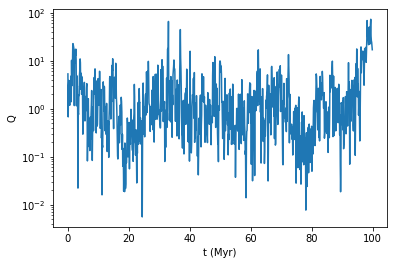

In [5]:
# work in Myr units
# set up light curve. pl_index of 1 means pink noise.
pl_index = 1            # pink noise
sigma = 1.5             # standard deviation in log-space
Age = 100.0             # length of time series (100 Myr)

# bend the power law at 1 Myr^-1 and steeply decay it beyond that with index 20. 
# A,v_bend,a_low,a_high, c - most of these are 1 or 0. 
PSD_params = (1, 1, pl_index, pl_index, 0)
tbin = 0.1                  # 100 kyr bins 
Length = int(Age / tbin)    # number of samples

# parameters of log-normal distribution (we normalise to 1!) 
# the terms here are sigma and the last term is the exponential 
# we set Q_0 =1 here but this could be changed 
Q_0 = 1
lnQ = np.log(Q_0)
lognorm_params = (sigma, 0, np.exp(lnQ))
    
# paramaters for lc are lognorm parameters, PSD parameters, tbin and Length (Age is really number of points)
lc = get_lc(lognorm_params, PSD_params, tbin, Length)

# make a plot
plt.plot(lc.time, lc.flux)
plt.xlabel("t (Myr)")
plt.ylabel("Q")
plt.semilogy()

# save the light curve to a file called Lightcurve.dat
data_to_save = np.column_stack((lc.time, lc.flux))
np.savetxt("Lightcurve.dat", data_to_save)

### Getting gamma 
Jet power is 
$$
Q = \Gamma (\Gamma - 1) \rho c^3 \beta A
$$
where $\beta=v/c$. We can invert this and solve numerically for \gamma by making ujse of $\beta=(1-\Gamma^{-2})^{1/2}$, such that
$$
(1-\Gamma^{-2})^{1/2} \Gamma (\Gamma - 1) - \frac{Q}{\rho c^3 A} = 0
$$
which can be solved using standard python packages, e.g. fsolve from scipy. 

Text(0, 0.5, '$\\Gamma$')

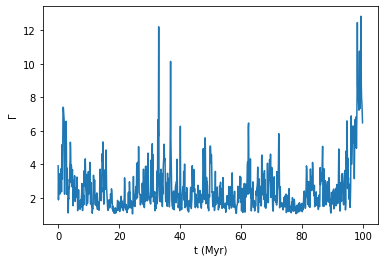

In [32]:
from scipy.optimize import fsolve

# median jet power in erg/s
Qmedian = 1e45

# read data from file 
time, flux = np.genfromtxt("Lightcurve.dat", unpack=True)

# constants and so on 
C = 2.997925e10
unit_density = 6e-27  # this is the unit density in the code
PARSEC = 3.086E18
rho_j = 1e-4
width = 1.0 * PARSEC * 1000.0 # 1kpc jet nozzle width
area = np.pi  * (width)**2

# array to store the gammas 
gammas = np.zeros_like(lc.flux)


for i in range(len(flux)):
    f = flux[i] * Qmedian

    # this is power over area over rho c**3
    X = f / area / n_j / unit_density / (C ** 3) 
    func = lambda gmm: np.sqrt(1-(gmm**-2)) * ((gmm**2) - gmm) - X

    # find gamma 
    gammas[i] = fsolve(func, 3.0)[0]
    

# make a plot
plt.plot(time, gammas)
plt.xlabel("t (Myr)")
plt.ylabel("$\Gamma$")  
plt.show()